# Steady-state advection-diffusion

Advection-diffusion problems study the *transport of substances* (e.g., chemicals, heat, or particles) influenced by both directional flow and random motion, governed by the advection-diffusion equation. At steady state, the interplay between convection and diffusion shapes the solution based on the velocity field and boundary conditions, with analytic solutions for simple geometries and numerical methods used for more complex cases.

## Problem setup

Consider a one-dimensional steady-state advection-diffusion problem where a field variable $\phi$ is transported through the advection-diffusion process from $x = 0$ to $x = L$ in a one-dimensional domain. The fluid density is $\rho = 1.0$ kg/m$^3$, $L = 1.0$ m, and the diffusion coefficient is $\Gamma = 0.1$ kg/(m$\cdot$s). As shown in the figure below, determine the distribution of $\phi$ on a grid discretized into 5 nodes when the velocity $u = 0.1$ m/s.

![Adiabatic rod](images/advection_diffusion1d.jpg)

The mathematical model for one-dimensional steady-state advection-diffusion problem is

$$\frac{\mathrm{d}}{\mathrm{d}x} \left( \rho u \phi \right) = \frac{\mathrm{d}}{\mathrm{d}x} \left( k\frac{\mathrm{d} \phi}{\mathrm{d}x} \right).$$

The boundary conditions are

$$\phi|_{x=0} = \phi_A = 1, \quad \phi|_{x=L} = \phi_B = 0.$$

The analytical solution for the temperature distribution at steady state is

$$\frac{\phi - \phi_A}{\phi_B - \phi_A} = \frac{\exp \left( \frac{\rho u x}{\Gamma} \right) - 1}{\exp \left( \frac{\rho u L}{\Gamma} \right) - 1}.$$

## Solve problem

### Define grid

Divide the rod evenly into 5 control volumes, as a result, the length of each control volume becomes $\delta x=0.2$ m.

![Grid](images/advection_diffusion1d_grid.jpg)

### Discrete advection-diffusion equation

Let $A_w = A_e = 1$, then $F = \rho u$ and $D = \frac{\Gamma}{\delta x}, with $F_e = F_w = F$ and $D_e = D_w = D$ holding for all control volumes. The discretized equations for the internal nodes 2, 3, and 4 are identical, while the boundary nodes 1 and 5 require special treatment.

**Internal Nodes 2, 3, 4**

The discrete equation satisfied by the internal nodes is

$$a_P \phi_P = a_W \phi_W + a_E \phi_E,$$

where

$$a_W = D_w + \frac{F_w}{2} = D + \frac{F}{2}, \quad a_E = D_e - \frac{F_e}{2} = D - \frac{F}{2}, \quad a_P = a_W + a_E + (F_e - F_w) = a_W + a_E.$$

**Boundary Nodes 1**

The discrete equation for the boundary node 1 is

$$a_P T_P = a_W T_W + a_E T_E + S_u,$$

where

$$a_W = 0, \quad a_E = D_e - \frac{F_e}{2} = D - \frac{F}{2}, \quad a_P = a_W + a_E + (F_e - F_w) - S_p = a_W + a_E - S_P,$$

$$S_P = -(2D_A + F_w) = -(2D + F), \quad S_u = (2D_A + F_A) \phi_A = (2D + F) \phi_A$$

**Boundary Nodes 5**

The discrete equation for the boundary node 1 is

$$a_P T_P = a_W T_W + a_E T_E + S_u,$$

where

$$a_W = D_w + \frac{F_w}{2} = D + \frac{F}{2}, \quad a_E = 0, \quad a_P = a_W + a_E + (F_e - F_w) - S_p = a_W + a_E - S_P,$$

$$S_P = -(2D_B + F_e) = -(2D - F), \quad S_u = (2D_B - F_B) \phi_A = (2D - F) \phi_B$$

### Solve algebraic equations

In [20]:
# Step 0: import required libraries
import numpy as np                      # for array operation
from matplotlib import pyplot as plt    # for plotting figures
import time                             # for time measurement

In [21]:
# Step 1: parameter declarations
nx = 5                                  # number of spatial grid points
L = 1.0                                 # length of the domain
dx = L / nx                             # spatial grid size
x = np.linspace(0.5*dx, L-0.5*dx, nx)   # spatial grid points
rho = 1.0                               # fluid density
u = 0.1                                 # fluid velocity
F = rho*u                               # advection flux
Gamma = 0.1                             # diffusion coefficient
D = Gamma/dx                            # diffusion conductance per unit area
phiA = 1                                # phi value at x = 0
phiB = 0                                # phi value at x = L

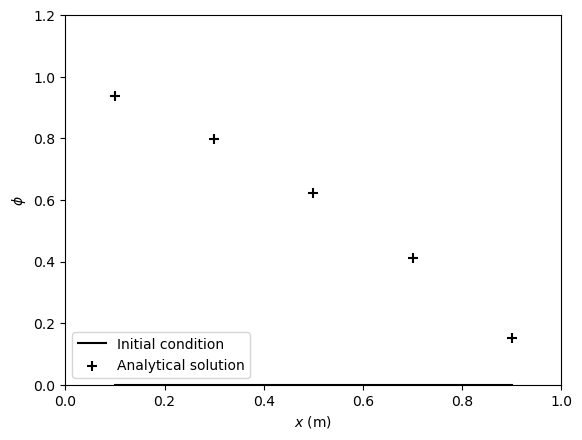

In [22]:
# Step 2.1: set initial condition
phi = np.zeros(nx)                      # a numpy array with nx elements all equal to zero

# Step 2.2: calculate analytical solution
phi_true = (np.exp(F*x/Gamma) - 1) / (np.exp(F*L/Gamma) - 1) * (phiB - phiA) + phiA

# Step 2.3: visualize initial condition and analytical solution
plt.figure()                            # create a new figure
plt.plot(x, phi, '-k', label='Initial condition')
plt.scatter(x, phi_true, s=50, c='k', marker='+', label='Analytical solution')
plt.xlabel('$x$ (m)')
plt.ylabel(r'$\phi$')
ax = plt.gca()
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.2)
plt.legend(loc='lower left')
plt.show()                              # show the figure

In [23]:
# Step 3: finite volume calculations
phi_old = np.zeros_like(phi)            # placeholder array to advance the solution
phi_diff = 1                            # phi difference for convergence
cnt = 0                                 # counter for the number of iterations
t_start = time.perf_counter()           # start time for performance measurement

while phi_diff > 1e-2:                  # loop until convergence
    cnt += 1                            # increment the counter
    phi_old = phi.copy()                # copy the current solution to the old solution

    # left boundary condition
    a_W, a_E = 0, D - F/2               # coefficients for the left boundary
    S_P = -(2*D + F)
    a_P = a_W + a_E - S_P
    S_u = (2*D + F) * phiA
    phi[0] = (a_E * phi_old[1] + S_u) / a_P # update the left boundary condition

    # internal nodes
    a_W, a_E = D + F/2, D - F/2         # coefficients for the internal nodes
    a_P = 2*D
    for i in range(1, nx-1):            # loop over the interior grid points
        phi[i] = (a_W * phi_old[i-1] + a_E * phi[i+1]) / a_P
    
    # right boundary condition
    a_W, a_E = D + F/2, 0               # coefficients for the right boundary
    S_P = -(2*D - F)
    a_P = a_W + a_E - S_P
    S_u = (2*D - F) * phiB
    phi[-1] = (a_W * phi_old[-2] + S_u) / a_P # update the right boundary condition

    # calculate the temperature difference for convergence
    phi_diff = np.sum(np.abs(phi - phi_old)) # total difference  
    print(phi)

# stop the timer and print the iteration results
t_end = time.perf_counter()
print('******************************************')
print('Final temperature difference: {:.7f}'.format(phi_diff))
print('Number of iterations: {}'.format(cnt))
print('Elapsed time: {:.3f} seconds'.format(t_end - t_start))

[0.70967742 0.         0.         0.         0.        ]
[0.70967742 0.39032258 0.         0.         0.        ]
[0.82299688 0.39032258 0.21467742 0.         0.        ]
[0.82299688 0.54925312 0.21467742 0.11807258 0.        ]
[0.869138   0.54925312 0.35522188 0.11807258 0.04478615]
[0.869138   0.63787575 0.35522188 0.2155258  0.04478615]
[0.89486715 0.63787575 0.44781827 0.2155258  0.08175117]
[0.89486715 0.69369516 0.44781827 0.28308807 0.08175117]
[0.91107279 0.69369516 0.50892197 0.28308807 0.10737823]
[0.91107279 0.73010492 0.50892197 0.32822729 0.10737823]
[0.92164336 0.73010492 0.54925999 0.32822729 0.12450001]
[0.92164336 0.75407084 0.54925999 0.35811799 0.12450001]
[0.92860121 0.75407084 0.57589206 0.35811799 0.13583786]
[0.92860121 0.76988209 0.57589206 0.37786767 0.13583786]
[0.93319158 0.76988209 0.5934756  0.37786767 0.14332912]
[0.93319158 0.78031939 0.5934756  0.39090968 0.14332912]
[0.93622176 0.78031939 0.60508502 0.39090968 0.14827609]
[0.93622176 0.78721023 0.605085

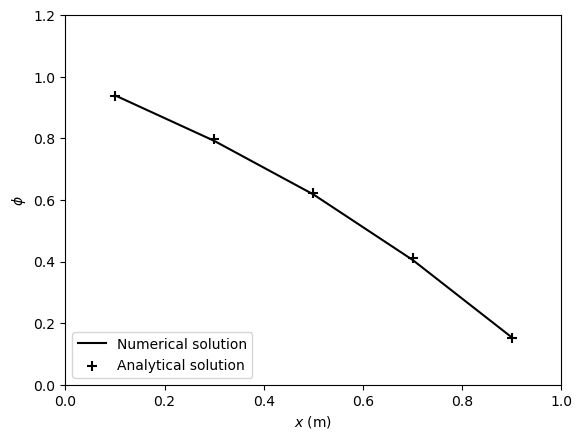

In [24]:
# Step 4: visualize the final solution
plt.figure()                            # create a new figure
plt.plot(x, phi, '-k', label='Numerical solution')
plt.scatter(x, phi_true, s=50, c='k', marker='+', label='Analytical solution')
plt.xlabel('$x$ (m)')
plt.ylabel(r'$\phi$')
ax = plt.gca()
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.2)
plt.legend(loc='lower left')
plt.show()                              # show the figure

## Exercise

1. Determine the distribution of $\phi$ on a grid discretized into 5 nodes when the velocity $u = 2.5$ m/s.

2. Determine the distribution of $\phi$ on a grid discretized into 20 nodes when the velocity $u = 2.5$ m/s.